# Deep Neural Networks using MXNet:


In multiclass logistic regression we mapped our inputs to the outputs using a single linear transformation.

If the labels are related to the input data by an approximately function, then this approach might be adequate. But <I>linearity is a strong assumption</I>. Linearity means that given an output of interest, for each input, increasing the value of the input should either drive the value of the output up or drive it down, irrespective of the value of the other inputs.

Imagine the case of classifying cats and dogs based on black and white images. That's like saying that for each pixel, increasing its value either increases the probability that it depicts a dog or decreases it. That's not reasonable. After all, there are both black dogs and black cats, and both white dogs and white cats.

In order to figure out what is depicted in the image generally requires allowing more complex relationships between our inputs and outputs, considering the possibility that our pattern might be characterized by interactions among the many features. In such cases the linear model, will have <I>low accuracy</I>. We can model a more general class of functions by incorporating one or more <I>hidden layers</I>. The most easiest way to do this is to stack a bunch of layers of neurons on top of each other. Each layer feeds into the layer above it unless we generate an output. This architecture is called "multilayer perceptron". With an MLP, we are going to stack a bunch of layers on top of each other.
$$\begin{eqnarray}
         h_1 &=& \phi(W_1(x) + b_1)\\
         h_2 &=& \phi(W_2(h_1) + b_2)\\
         \dots \\ 
         h_n &=& \phi(W_nh_{n-1} + b_n)
  \end{eqnarray}
$$

Note that each layer requires its own set of parameters. For each hidden layer, we calculate its value by first applying a linear function to the activations of the layers below, and then applying an element-wise nonlinear activation function. Here, I have denoted the activation functions for the hidden layers as $\phi$. Finally, given the topmost hidden layer, we will generate an output. Because, we are still focussing on multiclass classification, we will stick with the softmax activation in the output layer.
$$
     \bar y = softmax(W_yh_n + b_y)
$$

Multilayer perceptrons can account for complex interactions in the inputs because the hidden neurons depend on the values of each of the inputs. It's even widely known that multilayer perceptrons are universal approximators. That means that even for a single-hidden-layer neural network, with enough nodes, and the right set of weights, it could model any function at all! Actually learning those functions is the hard part. And it turns out that we can approximate functions much more compactly if we use deeper (vs wider) neural networks. In this example, we will implement a multilayer perceptron with two hidden layers and one output layer.

In [20]:
#import the relevant libraries
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon

### Set contexts:

In [21]:
ctx = mx.cpu()
data_ctx = ctx
model_ctx = ctx

### Load MNIST data:

In [22]:
num_inputs = 784
num_outputs = 10
batch_size = 64
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train = 1, transform = transform), batch_size, shuffle = 1)
test_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train = 0, transform = transform), batch_size, shuffle = 0)

### Allocate parameters:

In [23]:
# Set some constants so it's easy to modify the network later
num_hidden = 256
weight_scale = .01

#Allocate the parameters for the first hidden layer
W1 = nd.random_normal(shape = (num_inputs, num_hidden), scale = weight_scale, ctx = model_ctx)
b1 = nd.random_normal(shape = num_hidden, scale = weight_scale, ctx = model_ctx)

# Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (num_hidden, num_hidden), scale = weight_scale, ctx = model_ctx)
b2 = nd.random_normal(shape = num_hidden, scale = weight_scale, ctx = model_ctx)

# Allocate parameters for the output layer
W3 = nd.random_normal(shape = (num_hidden, num_outputs), scale = weight_scale, ctx = model_ctx)
b3 = nd.random_normal(shape = num_outputs, scale = weight_scale, ctx = model_ctx)

params = [W1, b1, W2, b2, W3, b3]

Allocating space for each parameter's gradient.

In [24]:
for param in params:
    param.attach_grad()

### Activation Functions:

If we compose multi-layer network but use only linear operations then our entire network will still be a linear function.
That's because $\bar y = X \cdot W_1 \cdot W_2 \cdot W_3 = X \cdot W_4$ for $ W_4 = W_1 \cdot W_2 \cdot W_3$.
To give our model the capacity to capture non-linear functions, we will need to interleave our linear operations with
activation functions.<br>
In this case we'll use <b>the rectified linear unit (ReLU)</b>.

In [25]:
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))

### Softmax Output:

As with multiclass logistic regression, we will want the output to be a valid probability distribution.
We'll use the <b>softmax activation</b> function on our output to make sure that our outputs sum to 1 and are non-negative.

In [26]:
 def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear))
    partition = nd.nansum(exp, axis = 0, exclude = 1).reshape((-1,1))
    return exp / partition

In [27]:
#Running the output through cross-entropy loss function
def cross_entropy(yhat, y):
    return -nd.nansum(y*nd.log(yhat), axis = 0, exclude = 1)

### The softmax cross-entropy loss function:

The softmax function calculates $\bar y_j = \frac {e^{z_j}}{\sum_{i=1}^ne^{z_i}}$, where $\bar y_j$ is the j-th element of the input `yhat` variable in `cross-entropy` function and $z_j$ is the j-th element of the input `y_linear` variable in function `softmax`.

If some $z_i$ is very large (i.e. very positive), then $e^{z_i}$ might be larger than the largest number we can have for certain types of `float` (i.e. overflow). This would make the denominator (and/or numerator) `infinite` and we get zero, or `infinite` or `nan` for $\bar y_j$. In any case we won't get a well defined return value for `cross_entropy`. This is the reason we subtract $max(z_i)$ from all $z_i$ first in `softmax` function. We can verify that this shifting in $z_i$ will not change the return value of `softmax`.

After the above subtraction/multiplication step, it is possible that $z_j$ is very negative. Thus, $e^{z_j}$ will be close to zero and might be rounded to zero due to finite precision (i.e. underflow), which makes $\bar y_j$ zero and we get `-infinite` for $log(\bar y_j)$. A few steps down the road in backpropagation it starts to get horrific not-a-number (`nan`) results printed to screen. 

Our salvation is that even though we are computing these exponential functions, we ultimately plan to take their log in the cross_entropy functions. It turns out that by combining the `softmax` and `cross_entropy` equations we can elude the numerical stability issues that otherwise might plague us during backpropagation. As shown in the equation below, we avoided calculating $e^{z_j}$ but directly used $z_j$ due to $log(exp(\cdot))$.
$$
    log(\bar y_j) = log \left(
                               \frac {e^{z_j}} {\sum_{i=1}^n e^{z_i}}
                         \right)
                  = log(e^{z_j}) - log \left(\sum_{i=1}^n e^{z_i}\right)
                  = z_j - log \left(\sum_{i=1}^n e^{z_i}\right)
$$
              
Now instead of passing softmax probabilities into our new loss function, we will just pass our `yhat_linear` and compute the softmax and its log all at once inside the softmax_cross_entropy loss function.

In [28]:
def softmax_cross_entropy(yhat_linear, y):
    return -nd.nansum(y * nd.log_softmax(yhat_linear), axis = 0, exclude = True)

### Defining the model:

In [29]:
def net(X):
    # Compute the first hidden layer
    h1_linear = nd.dot(X, W1) + b1
    h1 = relu(h1_linear)
    
    # Compute the second hidden layer
    h2_linear = nd.dot(h1, W2) + b2
    h2 = relu(h2_linear)
    
    # Compute the output layer.
    # We will omit the softmax function here
    # because it will be applied in the softmax_cross_entropy loss
    yhat_linear = nd.dot(h2, W3) + b3
    return yhat_linear

### Optimizer:

In [30]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr*param.grad

### Evaluation Metric:

In [31]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis = 1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

### Execute the training loop:

In [32]:
epochs = 10
learning_rate = .001
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
    
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch: %s. Loss: %s, Train_acc: %s, Test_acc: %s" %
         (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch: 0. Loss: 1.2316596712430319, Train_acc: 0.87943333, Test_acc: 0.8821
Epoch: 1. Loss: 0.33631670532226565, Train_acc: 0.9204, Test_acc: 0.9201
Epoch: 2. Loss: 0.22615769240061442, Train_acc: 0.9460667, Test_acc: 0.9448
Epoch: 3. Loss: 0.16544468241532645, Train_acc: 0.9619833, Test_acc: 0.9581
Epoch: 4. Loss: 0.12941680086652438, Train_acc: 0.9691833, Test_acc: 0.965
Epoch: 5. Loss: 0.10541769832670689, Train_acc: 0.9738333, Test_acc: 0.967
Epoch: 6. Loss: 0.0885169897776097, Train_acc: 0.9789, Test_acc: 0.9705
Epoch: 7. Loss: 0.07580567805568378, Train_acc: 0.983, Test_acc: 0.9729
Epoch: 8. Loss: 0.06475055932551622, Train_acc: 0.98536664, Test_acc: 0.9739
Epoch: 9. Loss: 0.057021041063219306, Train_acc: 0.9866167, Test_acc: 0.9736


### Using the model for prediction:

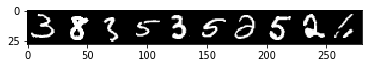

model predictions are: 
[3. 8. 3. 5. 3. 5. 8. 5. 2. 6.]
<NDArray 10 @cpu(0)>
true labels: 
[3. 8. 3. 5. 3. 5. 2. 5. 2. 6.]
<NDArray 10 @cpu(0)>


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

#Defining the function to do prediction
def model_predict(net, data):
    output = net(data)
    return nd.argmax(output, axis = 1)

samples = 10

mnist_test = mx.gluon.data.vision.MNIST(train=0, transform=transform)

#let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, samples, shuffle=1)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    im = nd.transpose(data, (1,0,2,3))
    im = nd.reshape(im, (28, 10*28, 1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred = model_predict(net, data.reshape((-1, 784)))
    print('model predictions are:', pred)
    print('true labels:', label)
    break

### Conclusion:

With just two hidden layers containing 256 hidden nodes, respectively, we can achieve over 95% accuracy on this task.